In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import cv2
import math
from scipy.signal import convolve2d
from scipy.stats import norm

### test image

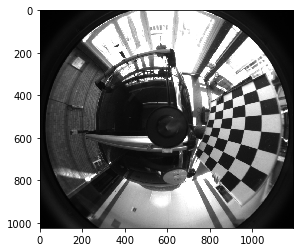

In [2]:
%matplotlib inline
image = plt.imread('../data/01.png')
plt.imshow(image, cmap = 'gray')

## createCorrelationPatch.m
done

In [3]:

class Template:
    def __init__(self, height, width):
        self.a1 = np.zeros((height, width))
        self.b1 = np.zeros((height, width))
        self.a2 = np.zeros((height, width))
        self.b2 = np.zeros((height, width))

    def do_normalize(self):
        self.a1 = self.a1 / np.sum(self.a1)
        self.a2 = self.a2 / np.sum(self.a2)
        self.b1 = self.b1 / np.sum(self.b1)
        self.b2 = self.b2 / np.sum(self.b2)


def createCorrelationPatch(properties):
    angle_1, angle_2, radius = properties

    width  = int(radius*2 + 1)
    height = int(radius*2 + 1)

    # initialize template
    template = Template(height, width)

    # midpoint
    mu = radius
    mv = radius

    # compute normals from angles
    n1 = [-np.sin(angle_1), np.cos(angle_1)]
    n2 = [-np.sin(angle_2), np.cos(angle_2)]

    # for all points in template do

    for v in range(0, height):
        for u in range(0, width):
            # vector
            vec = [u-mu, v-mv]
            dist = np.linalg.norm(vec)

            # check on which side of the normals we are
            s1 = np.matmul(vec, np.transpose(n1))
            s2 = np.matmul(vec, np.transpose(n2))

            if (s1 <= -0.1 and s2 <= -0.1):
                template.a1[v][u] = norm.pdf(dist, 0, radius/2) # x, mu, sigma
            elif (s1 >= 0.1 and s2 >= 0.1):
                template.a2[v][u] = norm.pdf(dist, 0, radius/2)
            elif (s1 <= -0.1 and s2 >= 0.1):
                template.b1[v][u] = norm.pdf(dist, 0, radius/2)
            elif (s1 >= 0.1 and s2 <= -0.1):
                template.b2[v][u] = norm.pdf(dist, 0, radius/2)

    # normalize
    template.do_normalize()
    return template

## nonMaximumSuppression.m
maxima same

In [4]:
def nonMaximumSuppression(img, n, tau, margin):
    height, width = img.shape
    maxima = []

    for j in range(n + margin, height - n - margin + 1, n + 1):
        for i in range(n + margin, width - n - margin + 1, n + 1):
            # initial value
            maxi, maxj = i, j
            maxval = img[j][i]
            # update maxval if found

            for j2 in range(j, j + n + 1):
                for i2 in range(i, i + n + 1):
                    if (img[j2][i2] > maxval):
                        maxi, maxj = i2, j2
                        maxval = img[j2][i2]

            failed = 0

            for j2 in range(maxj - n, min(maxj + n, height - margin) + 1):
                for i2 in range(maxi - n, min(maxi + n, width - margin) + 1):
                    currval = img[j2][i2]
                    if (currval > maxval and (i2 < i or i2 > i + n or j2 < j or j2 > j + n)):
                        failed = 1
                        break
                if (failed):
                    break

            if (maxval >= tau and failed == 0):
                maxima.append([maxi, maxj])

    maxima = np.array(maxima)

    return maxima



## findCorners.m

In [5]:
def findCorners(img, tau, radius):
    # filter image
    print('Start Filtering ...')

    # template properties
    template_props = [[0, np.pi / 2, radius[0]],
                      [np.pi / 4, -np.pi / 4, radius[0]],
                      [0, np.pi / 2, radius[1]],
                      [np.pi / 4, -np.pi / 4, radius[1]],
                      [0, np.pi / 2, radius[2]],
                      [np.pi / 4, -np.pi / 4, radius[2]]]

    img_corners = np.zeros(img.shape)
    for i in range(0, len(template_props)):
        # create correlation template
        template = createCorrelationPatch(template_props[i])

        # filter image according with current template
        img_corners_a1 = convolve2d(img, template.a1, 'same')
        img_corners_a2 = convolve2d(img, template.a2, 'same')
        img_corners_b1 = convolve2d(img, template.b1, 'same')
        img_corners_b2 = convolve2d(img, template.b2, 'same')

        # compute mean
        img_corners_mu = (img_corners_a1 + img_corners_a2 + img_corners_b1 + img_corners_b2) / 4
        # case 1: a=white, b=black
        img_corners_a = np.minimum(np.subtract(img_corners_a1, img_corners_mu),
                                   np.subtract(img_corners_a2, img_corners_mu))
        img_corners_b = np.minimum(np.subtract(img_corners_mu, img_corners_b1),
                                   np.subtract(img_corners_mu, img_corners_b2))
        img_corners_1 = np.minimum(img_corners_a, img_corners_b)

        # case 2: a=black, b=white
        img_corners_a = np.minimum(np.subtract(img_corners_mu, img_corners_a1),
                                   np.subtract(img_corners_mu, img_corners_a2))
        img_corners_b = np.minimum(np.subtract(img_corners_b1, img_corners_mu),
                                   np.subtract(img_corners_b2, img_corners_mu))
        img_corners_2 = np.minimum(img_corners_a, img_corners_b)

        # update corner map
        img_corners = np.maximum(img_corners, img_corners_1)
        img_corners = np.maximum(img_corners, img_corners_2)

    return img_corners


## compute image derivatives

In [6]:

def get_img_derivatives(img):
    # sobel masks
    du = [[-1, 0, 1],
          [-1, 0, 1],
          [-1, 0, 1]]

    dv = [[-1, -1, -1],
          [0, 0, 0],
          [1, 1, 1]]

    img_du = convolve2d(img, du, mode='same')
    img_dv = convolve2d(img, dv, mode='same')
    img_angle = np.arctan2(img_dv, img_du)
    img_weight = np.sqrt(img_du ** 2 + img_dv ** 2)

    # correct angle to lie in between [0,pi]
    h, w = img_angle.shape
    for i in range(0, h):
        for j in range(0, w):
            if (img_angle[i][j] < 0):
                img_angle[i][j] += np.pi
            elif (img_angle[i][j] > np.pi):
                img_angle[i][j] -= np.pi

    return img_du, img_dv, img_angle, img_weight

## findModesMeanShift.m
done

In [7]:

def findModesMeanShift(hist, sigma):
    # efficient mean-shift approximation by histogram smoothing

    # compute smoothed histogram
    hist_smoothed = np.zeros((len(hist)))
    for i in range(0, len(hist)):
        j = np.arange(-np.round(2 * sigma), np.round(2 * sigma) + 1)
        idx = np.mod(i + j, len(hist))
        hist_smoothed[i] = np.sum(hist[idx] * norm.pdf(j, 0, sigma))

    modes = []
    # check if at least one entry is non-zero
    # (otherwise mode finding may run infinitly)
    if np.abs(hist_smoothed - hist_smoothed[0]).any() < 1e-5:
        return

    modes = np.empty((0, 2), float)
    # mode finding
    for i in range(0, len(hist_smoothed)):
        j = i
        while (1):
            j1 = np.mod(j + 1, len(hist))
            j2 = np.mod(j - 1, len(hist))
            h0 = hist_smoothed[j]
            h1 = hist_smoothed[j1]
            h2 = hist_smoothed[j2]
            if (h1 >= h0 and h1 >= h2):
                j = j1
            elif (h2 > h0 and h2 > h1):
                j = j2
            else:
                break

        if len(modes) == 0:
            modes = np.array([[j, hist_smoothed[j]]])
        elif (j not in modes[:, 0]):
            new = np.array([[j, hist_smoothed[j]]])
            modes = np.concatenate((modes, new))

    # sort in descending order
    modes = modes[np.argsort(-modes[:, 1])]

    return modes, hist_smoothed


In [67]:

def edgeOrientations(img_angle, img_weight):
    # init v1 and v2
    v1 = [0, 0]
    v2 = [0, 0]

    # number of bins (histogram parameters)
    bin_num = 32

    # convert images to vectors
    vec_angle = img_angle.T.reshape(-1)
    vec_weight = img_weight.T.reshape(-1)

    # convert angles from normals to directions
    vec_angle = vec_angle + np.pi / 2
    vec_angle[vec_angle > np.pi] -= np.pi

    # create histogram
    angle_hist = np.zeros((bin_num))
    for i in range(0, len(vec_angle)):
        bin = int(max(min(np.floor(vec_angle[i] / (np.pi / bin_num)), bin_num - 1), 0))
        angle_hist[bin] = angle_hist[bin] + vec_weight[i];

    modes, angle_hist_smoothed = findModesMeanShift(angle_hist, 1);

    # if only one or no mode => return invalid corner
    if (len(modes) <= 1):
        return v1, v2

    # compute orientation at modes
    new = modes[:, 0] * np.pi / bin_num
    new = np.reshape(new, (-1, 1))
    modes = np.hstack((modes, new))

    # extract 2 strongest modes and sort by angle
    modes = modes[:2]
    modes = modes[np.argsort(modes[:, 2])]

    # compute angle between modes
    delta_angle = min(modes[1, 2] - modes[0, 2], modes[0, 2] + np.pi - modes[1, 2])

    # if angle too small => return invalid corner
    if (delta_angle <= 0.3):
        return v1, v2

    # set statistics: orientations
    v1 = [np.cos(modes[0, 2]), np.sin(modes[0, 2])]
    v2 = [np.cos(modes[1, 2]), np.sin(modes[1, 2])]

    return v1, v2

## refineCorners.m

In [68]:
class Corners:
    def __init__(self, NMS_corners):
        self.p = NMS_corners.astype(float)
        # init orientations to invalid (corner is invalid iff orientation=0)
        self.v1 = np.zeros(NMS_corners.shape)
        self.v2 = np.zeros(NMS_corners.shape)
        self.score = []
        
def refineCorners(img_du, img_dv, img_angle, img_weight, NMS_corners, r):

    print('Start Refining ...')
    corners = Corners(NMS_corners)
    height, width = img_du.shape

    idx_to_remove = []
    # for all corners do
    for i in range(0, len(corners.p)):
        # extract current corner location
        cu, cv = corners.p[i]
        cu = int(cu)
        cv = int(cv)
        # estimate edge orientations
        img_angle_sub  = img_angle[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
        img_weight_sub = img_weight[max(cv-r, 0):min(cv+r+1, height), max(cu-r, 0):min(cu+r+1, width)]
        v1, v2 = edgeOrientations(img_angle_sub, img_weight_sub)

        corners.v1[i] = v1
        corners.v2[i] = v2

        # continue, if invalid edge orientations
        if (v1 == [0, 0] or v2 == [0, 0]):
            continue
        #################################
        # corner orientation refinement #
        #################################

        A1 = np.zeros((2,2))
        A2 = np.zeros((2,2))

        for v in range(max(cv-r, 0), min(cv+r+1, height)):
            for u in range(max(cu-r, 0), min(cu+r+1, width)):
                # pixel orientation vector
                o = [img_du[v, u], img_dv[v, u]]
                if (np.linalg.norm(o) < 0.1):
                    continue
                o = o / np.linalg.norm(o)
                # robust refinement of orientation 1
                if(np.abs(np.matmul(o, v1)) < 0.25): # inlier?
                    A1[0] = A1[0] + img_du[v, u] * np.array([img_du[v, u], img_dv[v, u]])
                    A1[1] = A1[1] + img_dv[v, u] * np.array([img_du[v, u], img_dv[v, u]])

                # robust refinement of orientation 2
                if(np.abs(np.matmul(o, v2)) < 0.25): # inlier?
                    A2[0] = A2[0] + img_du[v, u] * np.array([img_du[v, u], img_dv[v, u]])
                    A2[1] = A2[1] + img_dv[v, u] * np.array([img_du[v, u], img_dv[v, u]])


        # set new corner orientation

        foo1, v1 = LA.eig(A1)      # eigenvalue, eigenvector
        min_eigenval_idx = np.argmin(foo1)
        v1 = v1[:, min_eigenval_idx]
        corners.v1[i] = v1

        foo2, v2 = LA.eig(A2)
        min_eigenval_idx = np.argmin(foo2)
        v2 = v2[:,min_eigenval_idx]
        corners.v2[i] = v2

        ##############################
        # corner location refinement #
        ##############################
        G = np.zeros((2,2))
        b = np.zeros((2,1))

        for v in range(max(cv - r, 0), min(cv + r+1, height)):
            for u in range(max(cu-r, 0), min(cu+r+1, width)):
                # pixel orientation vector
                o = [img_du[v, u], img_dv[v, u]]
                if (np.linalg.norm(o) < 0.1):
                    continue
                o = o / np.linalg.norm(o)

                # robust subpixel corner estimation
                if (cu != u or v != cv): # do not consider center pixel

                    #compute rel. position of pixel and distance to vectors
                    w = np.subtract([u, v], [cu, cv])
                    d1 = np.linalg.norm(w - np.matmul(w, v1) * v1)
                    d2 = np.linalg.norm(w - np.matmul(w, v2) * v2)

                    # if pixel corresponds with either of the vectors / directions
                    if ((d1 < 3 and np.abs(np.matmul(o, v1)) < 0.25) or (d2 < 3 and np.abs(np.matmul(o, v2)) < 0.25)):
                        du = img_du[v, u]
                        dv = img_dv[v, u]
                        H = np.matmul(np.transpose([[du, dv]]), np.array([[du, dv]]))
                        G = G + H
                        b = np.add(b, np.matmul(H, np.array(np.transpose([[u, v]]))))

        # set new corner location if G has full rank
        if (LA.matrix_rank(G) == 2):
            corner_pos_old = corners.p[i]
            corner_pos_new = np.transpose(np.matmul(LA.inv(G), b))

            # set corner to invalid, if position update is very large
            if (np.linalg.norm(corner_pos_new - corner_pos_old) >= 4):
                idx_to_remove.append(i)
                corners.v1[i] = [0, 0]
                corners.v2[i] = [0, 0]

            corners.p[i] = corner_pos_new ######

        # otherwise: set corner to invalid
        else:
            idx_to_remove.append(i)
            corners.v1[i] = [0, 0]
            corners.v2[i] = [0, 0]

    # remove corners without edges
    corners.p = np.delete(corners.p, idx_to_remove, 0)
    corners.v1 = np.delete(corners.v1, idx_to_remove, 0)
    corners.v2 = np.delete(corners.v2, idx_to_remove, 0)

    return corners

## def cornerCorrelationScore(img, img_weight, v1, v2):

In [69]:

def cornerCorrelationScore(img, img_weight, v1, v2):
    # center
    center = (img_weight.shape[0] + 1) / 2
    c = [center - 1, center - 1]
    img_filter = -1 * np.ones(img_weight.shape)

    # compute gradient filter kernel (bandwith = 3 px)
    for y in range(0, img_weight.shape[0]):
         for x in range(0, img_weight.shape[1]):
            p1 = np.subtract([x, y], c)
            p2 = np.matmul(p1, v1) * v1
            p3 = np.matmul(p1, v2) * v2

            if (np.linalg.norm(p1 - p2) <= 1.5 or np.linalg.norm(p1 - p3) <= 1.5):
                img_filter[y, x] = 1

    # convert into vectors
    vec_weight = np.transpose(img_weight).reshape(-1, 1)
    vec_filter = np.transpose(img_filter).reshape(-1, 1)

    # normalize
    vec_weight = (vec_weight - np.mean(vec_weight)) / np.std(vec_weight)
    vec_filter = (vec_filter - np.mean(vec_filter)) / np.std(vec_filter)

    # compute gradient score
    score_gradient = max(np.sum(vec_weight * vec_filter) / (len(vec_weight) - 1), 0)

    # create intensity filter kernel
    template = createCorrelationPatch([np.arctan2(v1[1], v1[0]), np.arctan2(v2[1], v2[0]), c[0]])

    # checkerboard responses
    a1 = np.sum(template.a1 * img)
    a2 = np.sum(template.a2 * img)
    b1 = np.sum(template.b1 * img)
    b2 = np.sum(template.b2 * img)

    mu = (a1 + a2 + b1 + b2) / 4

    # case 1: a=white, b=black
    score_a = min(a1 - mu, a2 - mu)
    score_b = min(mu - b1, mu - b2)
    score_1 = min(score_a, score_b)

    # case 2: b=white, a=black
    score_a = min(mu - a1, mu - a2)
    score_b = min(b1 - mu, b2 - mu)
    score_2 = min(score_a, score_b)

    # intensity score: max. of the 2 cases
    score_intensity = max(max(score_1, score_2), 0)
    if(np.isnan(score_intensity)):
        score_intensity = 0
    # final score: product of gradient and intensity score
    score = score_gradient * score_intensity

    return score

In [70]:
def scoreCorners(img, img_angle, img_weight, corners, radius, tau):

    print('Start Scoring ...')
    height, width = img.shape
    idx_to_remove = []
    # for all corners do
    for i in range(0, len(corners.p)):
        # corner location
        u, v = np.round(corners.p[i])
        u = int(u)
        v = int(v)
        # compute corner statistics @ radius 1
        score_list = [0, 0, 0]
        for j in range(0, len(radius)):
            if(v - radius[j] >= 0 and v + radius[j] + 1 <= height and u - radius[j] >= 0 and u + radius[j] + 1 <= width):
            #if(u > radius[j] and u <= width-radius[j] and v > radius[j] and v<= height-radius[j]):
                img_sub         = img       [v - radius[j]:v + radius[j] + 1, u - radius[j]:u + radius[j] + 1]
                img_angle_sub   = img_angle [v - radius[j]:v + radius[j] + 1, u - radius[j]:u + radius[j] + 1]
                img_weight_sub  = img_weight[v - radius[j]:v + radius[j] + 1, u - radius[j]:u + radius[j] + 1]
                score_list[j]   = cornerCorrelationScore(img_sub, img_weight_sub, corners.v1[i, :], corners.v2[i, :])

        max_score = np.max(score_list)
        # take highest score
        corners.score.append(max_score)
        if(max_score < tau or np.isnan(max_score)):
            idx_to_remove.append(i)

    # remove corners without edges
    corners.p   = np.delete(corners.p, idx_to_remove, 0)
    corners.v1  = np.delete(corners.v1, idx_to_remove, 0)
    corners.v2  = np.delete(corners.v2, idx_to_remove, 0)
    corners.score = np.delete(corners.score, idx_to_remove, 0)

    return corners

In [71]:
def plotCorners(img, corners):
    plt.figure(figsize = (16, 8))
    implot = plt.imshow(img)
    plt.scatter(corners[:, 0], corners[:, 1], color = 'red')
    plt.show()

    return 0

## demo.m

In [72]:
img = plt.imread('../data/01.png')

# use 3 scales to obtain a modest level of scale invariance and robustness w.r.t blur
radius = [4, 8, 12]

# normalize values between [0, 1]
img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# convert to grayscale image
if (len(img.shape) == 3):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


# compute image derivatives
img_du, img_dv, img_angle, img_weight = get_img_derivatives(img)

# scale input image
img = (img - np.min(img)) / (np.max(img) - np.min(img))

# find initial corners
initial_corners = findCorners(img, 0.01, radius)

# extract corner candidates via non maximum suppressions
NMS_corners = nonMaximumSuppression(initial_corners, 3, 0.025, 5)


Start Filtering ...


Start Refining ...


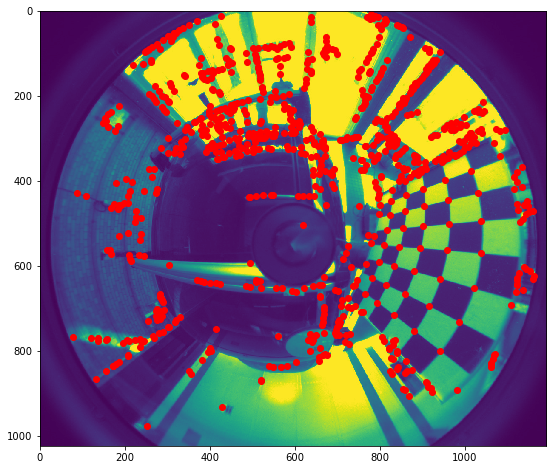

0

In [73]:
# subpixel refinement
refined_corners = refineCorners(img_du, img_dv, img_angle, img_weight, NMS_corners, 10)
plotCorners(img, refined_corners.p)

Start Scoring ...


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


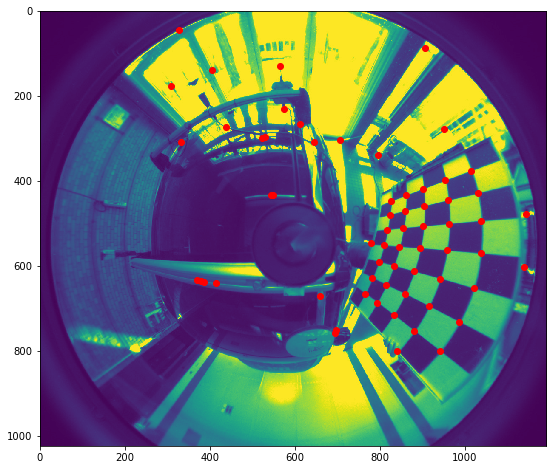

In [74]:
# score corners
final_corners = scoreCorners(img, img_angle, img_weight, refined_corners, radius, 0.01)
plotCorners(img, final_corners.p)

# make v1(:,1)+v1(:,2) positive
idx = final_corners.v1[:, 0] + final_corners.v1[:, 1] < 0
final_corners.v1[idx, :] = -final_corners.v1[idx, :]


### sort corners in x ascending order (to compare with matlab)

In [598]:
corners = final_corners

[ 4  0 12 45 46 47  3 48  7  9 10 19 20  2  5  6 13 53 60 58 11 51 33 43 54
 14 39 34 49 32 26 22 56 40 61 35 31 52 25 21 42 59 36 17 30 24  1 55 44 62
  8 16 37 23 29 57 15 50 18 38 28 41 27]


In [581]:
sorted_idx = final_corners.p[:,0].argsort()
corners.p = final_corners.p[sorted_idx]
corners.v1 = final_corners.v1[sorted_idx]
corners.v2 = final_corners.v2[sorted_idx]
corners.score = final_corners.score[sorted_idx]

## chessboardsFromCorners

In [555]:
def directionalNeighbor(idx, v, chessboard, corners):
    
    # list of neighboring elements, which are currently not in use
    unused = np.arange(0, corners.p.shape[0])
    used = chessboard[chessboard != -1]
    unused = np.delete(unused, used)

    # direction and distance to unused corners
    dir = corners.p[unused, :] - np.ones((len(unused), 1)) * corners.p[idx, :]
    dist = (dir[:,0] * v[0] + dir[:,1] * v[1]).reshape(-1,1)
    
    dist_edge = np.subtract(dir, dist*v)
    dist_edge = np.sqrt(dist_edge[:, 0]**2 + dist_edge[:, 1]**2).reshape(-1, 1)
    dist_point = dist
    dist_point[dist_point<0] = np.inf
    
    #find best neighbor
    min_idx = np.argmin(dist_point + 5 * dist_edge)
    min_dist = np.min(dist_point +  5 * dist_edge)
    neighbor_idx = unused[min_idx]
    
    return neighbor_idx, min_dist

In [556]:
def initChessboard(corners, idx):
    # not enough corners
    if (corners.p.shape[0] < 9):
        return []
    
    # init chessboard hypothesis
    chessboard = -np.ones((3, 3), dtype = int)
    
    # extract feature index and orientation (central element)
    v1 = corners.v1[idx, :]
    v2 = corners.v2[idx, :]
    chessboard[1, 1]= idx
    
    # find left/right/top/bottom neighbors
    dist1 = np.empty((2, 1))
    dist2 = np.empty((6, 1))
    chessboard[1,2],dist1[0] = directionalNeighbor(idx,+v1,chessboard,corners)
    chessboard[1,0],dist1[1] = directionalNeighbor(idx,-v1,chessboard,corners)
    chessboard[2,1],dist2[0] = directionalNeighbor(idx,+v2,chessboard,corners)
    chessboard[0,1],dist2[1] = directionalNeighbor(idx,-v2,chessboard,corners)
    
    # find top-left/top-right/bottom-left/bottom-right neighbors 
    chessboard[0,0],dist2[2] = directionalNeighbor(chessboard[1,0],-v2,chessboard,corners)
    chessboard[2,0],dist2[3] = directionalNeighbor(chessboard[1,0],+v2,chessboard,corners)
    chessboard[0,2],dist2[4] = directionalNeighbor(chessboard[1,2],-v2,chessboard,corners)
    chessboard[2,2],dist2[5] = directionalNeighbor(chessboard[1,2],+v2,chessboard,corners)

    # initialization must be homogenously distributed
    if(any(np.isinf(dist1)) or any(np.isinf(dist2)) or np.std(dist1)/np.mean(dist1) > 0.3 or np.std(dist2)/np.mean(dist2) > 0.3):
        return []
    
    return chessboard

In [634]:
def chessboardEnergy(chessboard, corners):
    
    h, w = chessboard.shape
    # energy: number of corners
    E_corners = - h * w
    
    # energy: structure
    E_structure = 0
    
    # walk through rows
    for j in range(0, h):
        for k in range(0, w-2):
            x = corners.p[chessboard[j, k:k+3]]
            E_structure = max(E_structure, np.linalg.norm(x[0,:]+x[2,:]-2*x[1,:])/np.linalg.norm(x[0,:]-x[2,:]))
            
    # walk through columns
    for j in range(0, w):
        for k in range(0, h-2):
            x = corners.p[chessboard[k:k+3, j]]
            E_structure = max(E_structure, np.linalg.norm(x[0,:]+x[2,:]-2*x[1,:])/np.linalg.norm(x[0,:]-x[2,:]))
    
    
    
    E = E_corners + h*w*E_structure
    
    return E

In [643]:
def growChessboard(chessboard, corners, border_type):
    
    # return immediately, if there do not exist any chessboards
    if(len(chessboard) == 0):
        return []
    # extract feature locations
    p = corners.p
    
    # list of unused feature elements
    unused = np.arange(0, corners.p.shape[0])
    used = chessboard[chessboard != -1]
    unused = np.delete(unused, used)
    
    # candidates from unused corners
    cand = p[unused, :]
    
    # switch border type 1 ~ 4
    if (border_type == 0):
        pred = predict
        
        
        
    
    elif (border_type == 1):
        
        
    
    
    return chessboard

IndentationError: expected an indented block (<ipython-input-643-6ae557359189>, line 21)

In [642]:
print('Start Structure Recovery ...')

# initialize chessboards
chessboards = []

# for all seeds
for i in range(0,corners.p.shape[0]):
    # output
    if(i%100 == 0):
        print(i+1,"/",corners.p.shape[0])
    
    # init 3x3 chessboard from seed i
    chessboard = initChessboard(corners, i)
    
    if (len(chessboard) == 0 or chessboardEnergy(chessboard, corners) > 0):
        continue
        
    # try growing chessboard
    while(1):
        # compute current energy
        energy = chessboardEnergy(chessboard, corners)
        
        # compute proposals and energies
        for j in range(0, 4):
            proposal[j] = growChessboard(chessboard,corners,j);
            p_energy[j] = chessboardEnergy(proposal[j],corners);
        
        
        
    

Start Structure Recovery ...
1 / 63


IndexError: list assignment index out of range

In [599]:
chessboard_idx = [31,39,43,51,56,30,38,45,53,58,29,36,44,54,60,27,35,42,52,59,26,33,40,48,57,23,28,37,47,55,21,24,32,41,49]

chessboard_p = final_corners.p[chessboard_idx]

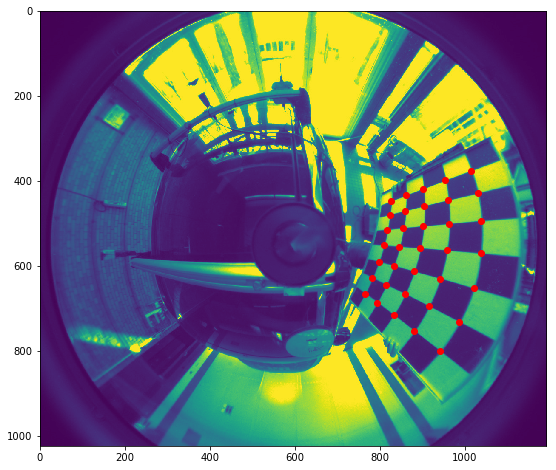

0

In [600]:
plotCorners(img, chessboard_p)

In [83]:
arr = {}
arr[0] = [[0, 0, 0], [0, 0, 0]]
arr[1] = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
arr[3] = 1

In [84]:
print(arr)

{0: [[0, 0, 0], [0, 0, 0]], 1: [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 3: 1}


In [85]:
print(len(arr))

3
